# Final Exam

20234748 나선우

### Notice

1. Build a model that can predict fraudulent transactions by using a random forest algorithm. (50 points)
- Describe what is the best performance for the model and build the best-performing model.

2. Explain the results in detail and provide your insights. (50 points)
- SHAP values should be used.

In [7]:
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import shap
import xgboost as xgb
import pandas as pd

# 1. EDA

In [8]:
df = pd.read_csv('card_fraud_small.csv')
df_origin = df.copy()

In [9]:
pd.set_option('display.max_columns', None)
df.head(3)

,ID,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,943140,14.515270,50.554625,14.430739,1,0,1,1,1
1,737340,61.121933,0.665601,12.093035,1,0,0,1,1
2,16026,30.868915,81.452963,0.728938,1,0,0,1,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              2625 non-null   int64  
 1   distance_from_home              2625 non-null   float64
 2   distance_from_last_transaction  2625 non-null   float64
 3   ratio_to_median_purchase_price  2625 non-null   float64
 4   repeat_retailer                 2625 non-null   int64  
 5   used_chip                       2625 non-null   int64  
 6   used_pin_number                 2625 non-null   int64  
 7   online_order                    2625 non-null   int64  
 8   fraud                           2625 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 184.7 KB


결측값 없음. 계속 진행 (총 2625개의 샘플 존재)

In [11]:
df.describe()

,ID,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000
mean,507314.785524,37.222942,7.001553,3.213887,0.886476,0.328000,0.086095,0.730286,0.338667
std,292442.369377,84.111677,32.953527,5.519383,0.317292,0.469574,0.280558,0.443896,0.473347
min,162.000000,0.030451,0.000635,0.015110,0.000000,0.000000,0.000000,0.000000,0.000000
25%,255984.000000,4.156380,0.300075,0.631815,1.000000,0.000000,0.000000,0.000000,0.000000
50%,516809.000000,10.626423,1.052334,1.484678,1.000000,0.000000,0.000000,1.000000,0.000000
75%,760457.000000,32.968394,3.620735,4.418899,1.000000,1.000000,0.000000,1.000000,1.000000
max,999685.000000,1504.870552,894.040957,146.213898,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
print('count by repeat_retailer')
display(df.groupby(['repeat_retailer']).count()['ID'])

print('count by used_chip')
display(df.groupby(['used_chip']).count()['ID'])

print('count by used_pin_number')
display(df.groupby(['used_pin_number']).count()['ID'])

print('count by online_order')
display(df.groupby(['online_order']).count()['ID'])

print('count by fraud')
display(df.groupby(['fraud']).count()['ID'])

count by repeat_retailer


repeat_retailer
0     298
1    2327
Name: ID, dtype: int64

count by used_chip


used_chip
0    1764
1     861
Name: ID, dtype: int64

count by used_pin_number


used_pin_number
0    2399
1     226
Name: ID, dtype: int64

count by online_order


online_order
0     708
1    1917
Name: ID, dtype: int64

count by fraud


fraud
0    1736
1     889
Name: ID, dtype: int64

In [26]:
len(df['ID'].unique())

2625

ID는 필요 없으므로 (2625개의 샘플 => 2625개의 서로 다른 ID 값) 삭제함.

In [27]:
df.drop(columns='ID', inplace=True)

In [30]:
df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']].corr()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
distance_from_home,1.000000,-0.016188,-0.044913
distance_from_last_transaction,-0.016188,1.000000,-0.019707
ratio_to_median_purchase_price,-0.044913,-0.019707,1.000000


연속형 변수 간 뚜렷한 상관관계는 보이지 않음.

# Building Models

범주형 자료와 연속형 자료가 섞여 있는 데이터셋이므로 SMTOENC를 활용하여 불균형 해소

In [53]:
X = df.drop(columns='fraud')
y = df.fraud

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

sm = SMOTENC(categorical_features=['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order'])
X_sm_train, y_sm_train = sm.fit_resample(X_train, y_train)

In [38]:
print('count by fraud')
y_sm_train.value_counts()

count by fraud


fraud
0    1302
1    1302
Name: count, dtype: int64

의도한 대로 SMOTENC가 잘 이루어졌음을 확인할 수 있음. 이제 RandomForest 모델 빌드.

In [55]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_sm_train, y_sm_train)

RandomForestClassifier(random_state=0)

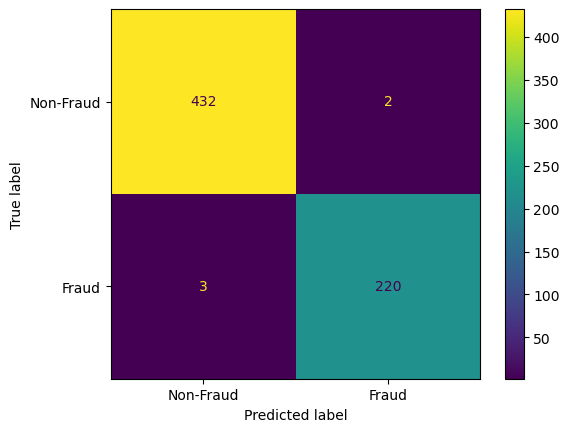

In [56]:
ConfusionMatrixDisplay.from_estimator(forest, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])

예상보다 빌드 상태가 매우 양호함.

In [43]:
print(classification_report(y_test, forest.predict(X_test), target_names=['Non-Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Non-Fraud       0.99      1.00      1.00       434
       Fraud       1.00      0.99      0.99       223

    accuracy                           0.99       657
   macro avg       0.99      0.99      0.99       657
weighted avg       0.99      0.99      0.99       657



Best parameters: {'max_depth': 3, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 100}


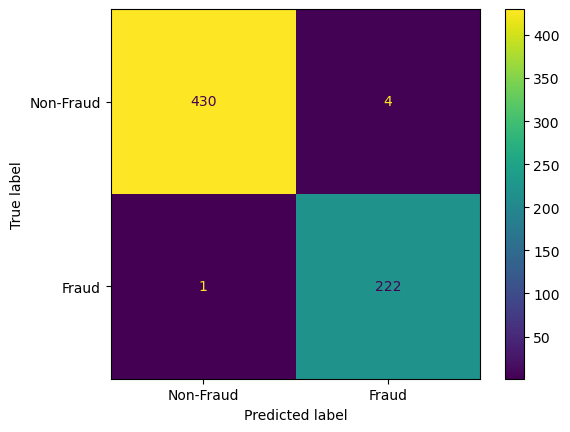

In [85]:
param_grid = {
    'n_estimators': [25, 50, 75, 100],
    'max_features': [2, 3, 4, 5, 6, 7],
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 3],
    #'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0),
    param_grid, scoring='recall', cv=5, return_train_score=True)
grid_search.fit(X_sm_train, y_sm_train)
print('Best parameters:', grid_search.best_params_)
model = grid_search.best_estimator_
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])
best_forest = model

처음에는 F1 스코어링을 이용하여 그리드 서치를 진행함. 이진분류이므로 accuracy보다 범용적으로 활용이 가능할 것 같기에 선정하였으나, 위에서 빌드한 기본 모델과 차이가 없어짐.

또한 Fraud detection 특성상 사기 거래에 매우 민감해야 함. FP는 사기 거래가 아닌데 사기로 판단한 것. 경우에 따라서 무고한 사람이 불편함을 입을 수 있으나, 카드망 전체에서 보면 아주 큰 위험은 아님. 혹여나 그런 일이 발생해도 해당 사람에게 보상을 해주는 방법이 있음.\
그러나 FN의 경우 사기 거래를 잡아내지 못한 것. 정상적인 결제를 방해한다는 점에서 카드망 전체에 악영향을 미침. 따라서 FN을 낮추지 못할 경우 매우 큰 위험이 따를 수 있음. FN의 값을 가능한 낮추는 Recall을 기준으로 그리드 서치를 진행함.

FN의 값이 66% 감소함. 다만 FP의 경우 두 배 증가한 모습을 보임.

Best parameters: {'learning_rate': 0.2, 'max_depth': 2}


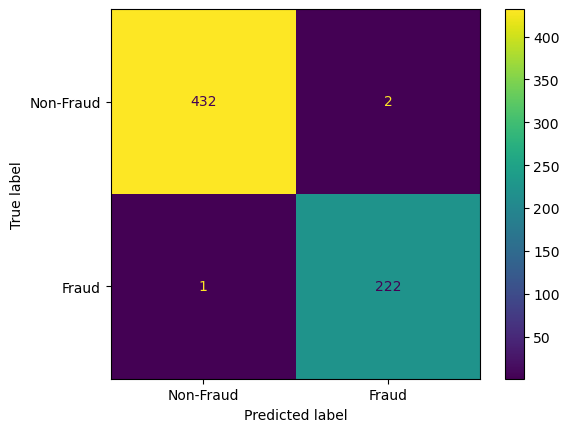

In [82]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'max_depth': [1, 2, 3, 4, 5, 6]
}

grid = GridSearchCV(xgb.XGBClassifier(random_state=0),
    param_grid, scoring='recall', cv=7, return_train_score=True)
grid.fit(X_sm_train, y_sm_train)
print('Best parameters:', grid.best_params_)

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])
best_xgb = grid.best_estimator_

**번외**: 추가로 XGBoost를 활용하여 모델을 만들어봄. max_depth=1, learning_rate=0.1인 경우 FP가 무려 0이 되는 기염을 토했으나 FN이 33으로, 상당수의 선량한 사람들이 불편을 초래할 것으로 예상되어 모델을 다시 빌드함. 상당히 만족할만한 결과가 나옴. 그러나 시험에서 요구되는 사항이 아니므로 더 이상 분석하진 않음.

# Model Explaination

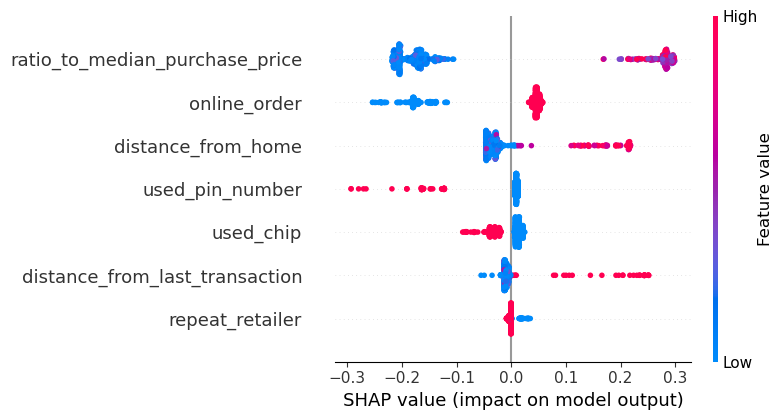

In [112]:
explainer = shap.Explainer(best_forest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

**위 그래프를 통해 알 수 있는 것은 다음과 같다**

1. Shap의 summary_plot은 모델에 큰 영향을 끼친 순으로 특성들을 배열한다. 즉, ratio_to_median_purchase_price가 가장 영향이 크다. 따라서 다음과 같은 순서대로 사기 탐지에 영향을 미침을 알 수 있다.
    - 거래 금액이 중위값에서 떨어진 정도
    - 온라인 거래인지 여부
    - 거주지에서 거래처가 떨어진 정도
    - 비밀번호를 사용했는지 여부
    - IC카드 등 칩이 달린 카드를 사용했는지 여부
    - 마지막 거래처로부터 떨어진 정도
    - 재구매 빈도
  
2. "거래 금액이 중위값에서 떨어진 정도"를 보면, 거래 금액이 높을수록 사기 거래임을 확인할 수 있다.
3. online_order는 0과 1의 값만 가지므로, 높은(1) 경우, 즉 **온라인 거래에서** 사기 거래가 많다.
4. 거주지에서 멀리 떨어질수록 사기 거래가 많다.
5. used_pin_number는 0과 1의 값만 가지므로, 낮은(0) 경우, 즉 **비밀번호를 사용하지 않은 거래**에서 사기가 많다.
6. used_chip은 0과 1의 값만 가지므로, 낮은(0) 경우, 즉 **chip을 사용하지 않은 거래**에서 사기 거래가 많다.
7. 마지막 거래처로부터 떨어진 정도가 클 수록 사기 거래일 확률이 높다.
8. 사기 거래의 경우 재구매 빈도가 낮다. 즉, 여기저기 옮겨다니며 사기 거래를 일으켰을 확률이 높다.

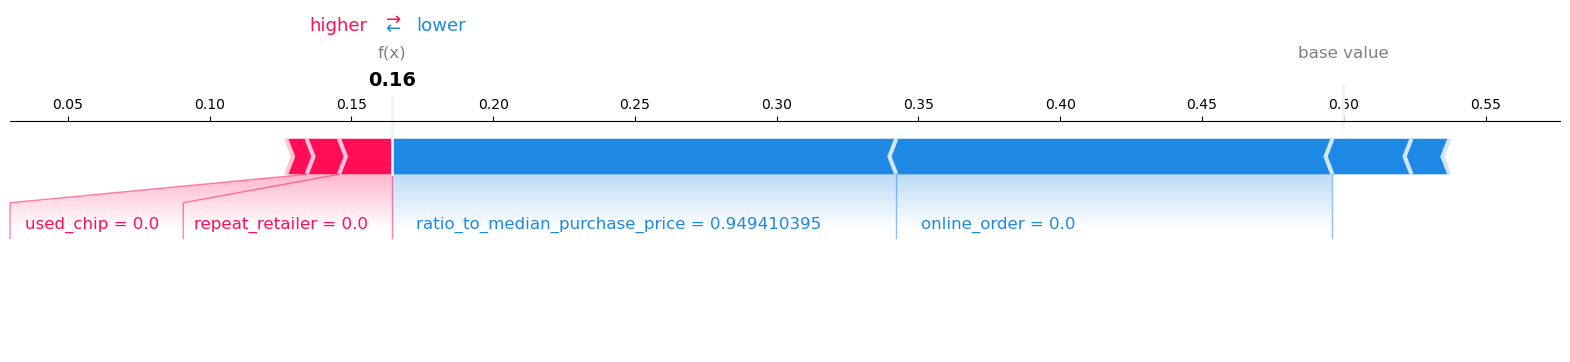

This sample is actually Non-Fraud


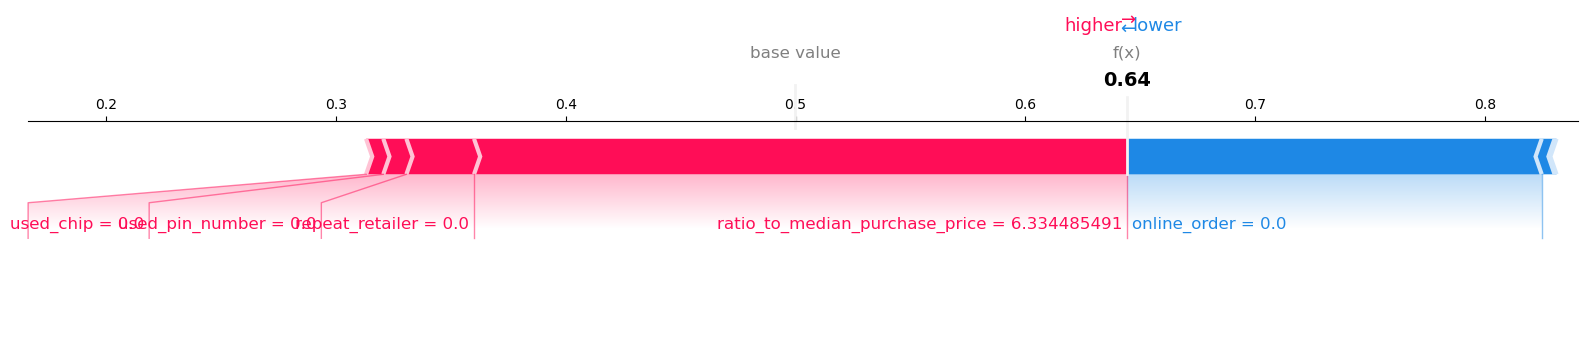

This sample is actually Fraud


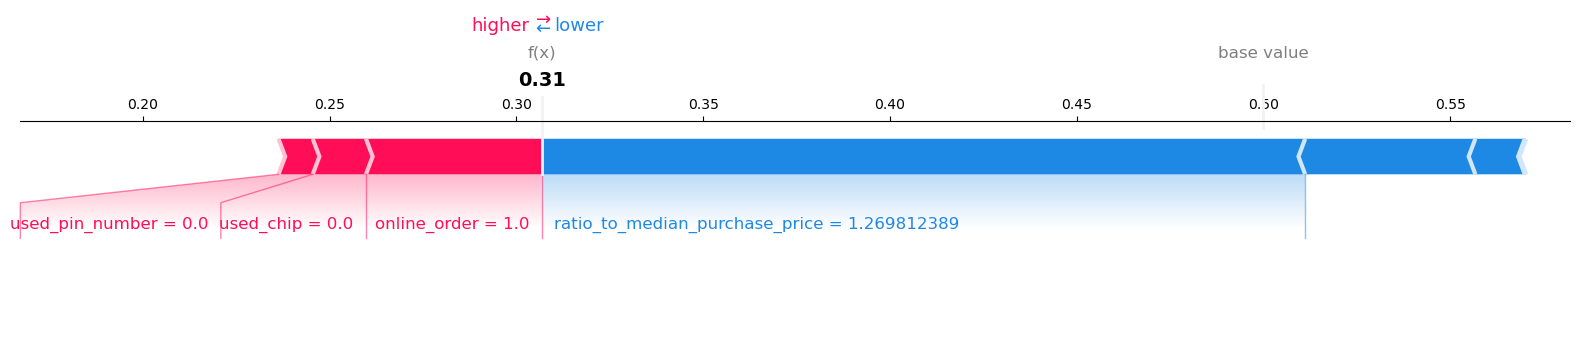

This sample is actually Non-Fraud


In [135]:
shap.initjs()
for i in range(1, 600, 200):
    shap.force_plot(explainer.expected_value[1], shap_values[1][i, :], X_test.iloc[i, :], matplotlib=True)
    print('This sample is actually', 'Non-Fraud' if y_test.iloc[i] == 0 else 'Fraud')

위에서 본 바와 동일하며, 대체로 금액이 사기 거래 판별에 큰 영향을 미친다. 위 그림에서 붉은 부분이 많을수록 Fraud일 확률이 높고, 푸른 부분이 많을수록 Non-Fraud일 확률이 높다. 대체로 모델의 예측이 정답과 일치한다.

In [118]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

대체로 오프라인 결제에서는 사기 거래가 아닌 경우가 많으며, 마찬가지로 거래 금액대가 중앙값보다 낮은 경우에도 사기 거래가 아닌 경우가 많다.\
다르게 보면, 사기 거래로 인해 거래액의 중앙값이 높아졌다고 볼 수도 있다.

**Q. 그렇다면 잘못 예측한 것들은 왜 잘못 예측했을까?**\
우선 실제와 다르게 예측한 샘플의 인덱스를 찾아보자.

In [131]:
l = best_forest.predict(X_test)
for i in range(len(l)):
    if l[i] != y_test.iloc[i]:
        print(i)

16
242
300
541
643


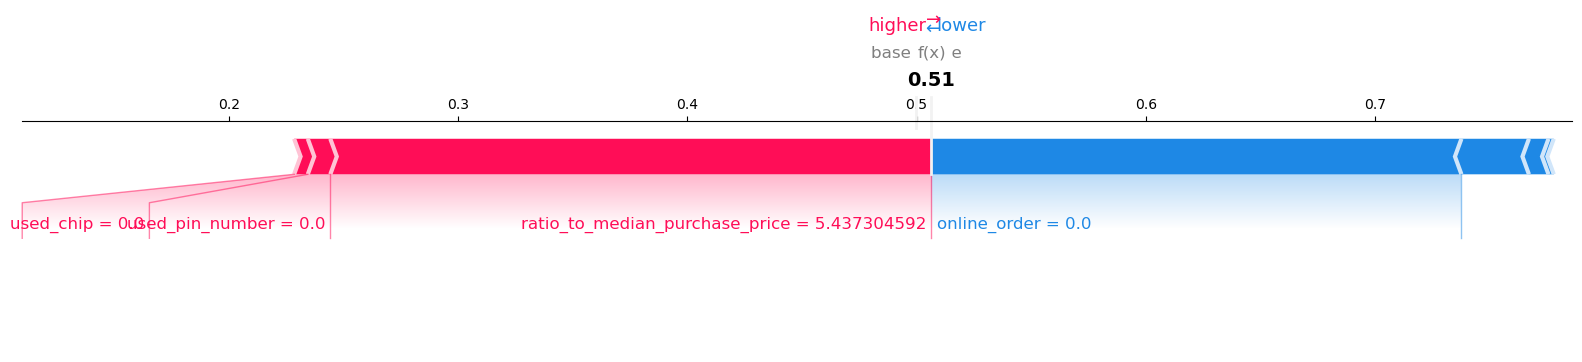

Sample 16: Actually Non-Fraud, but detected as Fraud


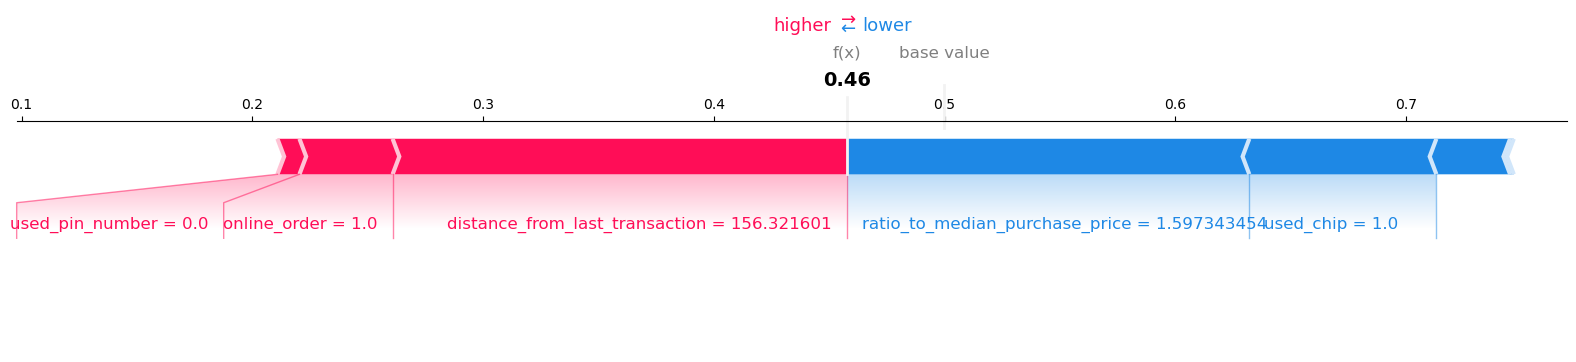

Sample 242: Actually Fraud, but detected as Non-Fraud


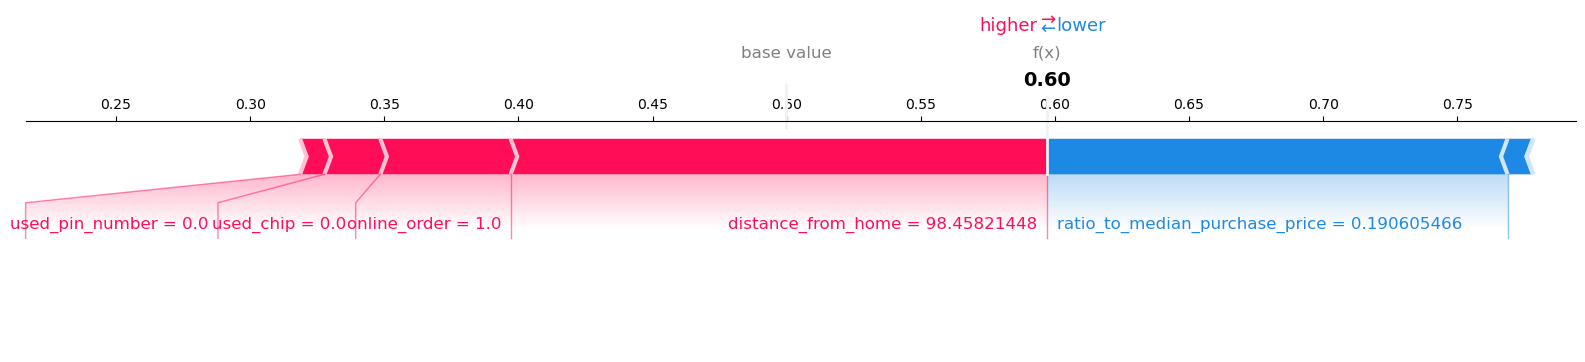

Sample 300: Actually Non-Fraud, but detected as Fraud


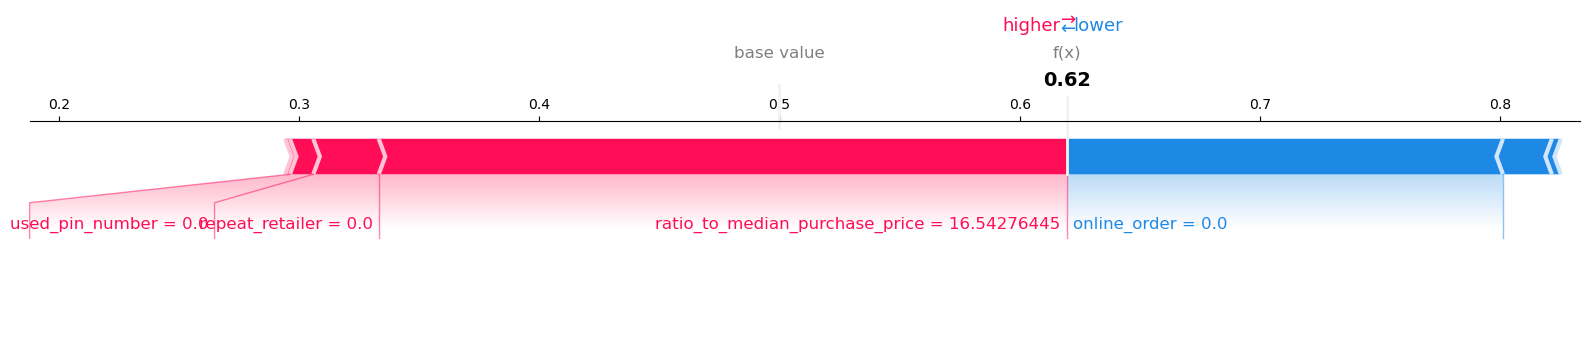

Sample 541: Actually Non-Fraud, but detected as Fraud


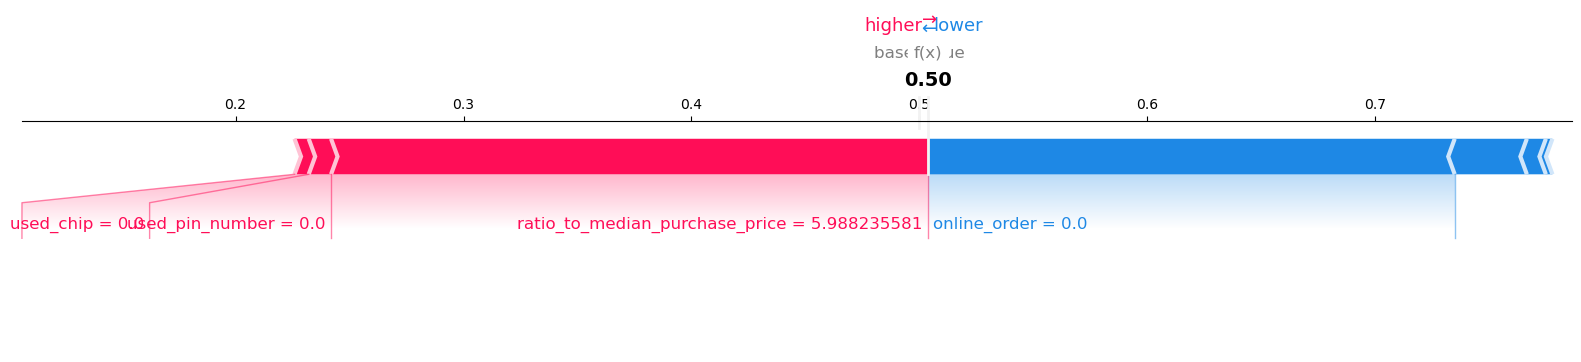

Sample 643: Actually Non-Fraud, but detected as Fraud


In [134]:
f = lambda x: {0: 'Non-Fraud', 1: 'Fraud'}.get(x)
for i in [16, 242, 300, 541, 643]:
    shap.force_plot(explainer.expected_value[1], shap_values[1][i, :], X_test.iloc[i, :], matplotlib=True)
    print(f'Sample {i}: Actually {f(y_test.iloc[i])}, but detected as {f(l[i])}')

16, 242, 643 샘플의 경우 값이 0.5에 거의 근접하여 제대로 분류하지 못했다.

- 16, 541, 643: 정상인 거래이나, 거래 금액이 중앙값에 비해 매우 크다는 이유로 사기로 분류되었다. 가전 등 일회성으로 비싼 물건을 산 걸 수도 있는데.
- 242: 사기인 거래이나, 거래 금액이 작고 칩을 사용했다는 이유로 정상으로 분류되었다.
- 300: 정상인 거래이나, 집에서 멀리 떨어진 곳에서 거래했다는 이유로 사기로 분류되었다. 여행을 간 걸 수도 있는데.

FP로 분류된 것들 중, 정상 거래의 금액이 매우 높은 경우 사기로 잘못 분류됨을 확인할 수 있었다.